In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/SpeckledBand090/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2022-12-31 18:16:44 - INFO - 2341293231.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/SpeckledBand090/03/log.log', param_file='saved_models/kgc/SpeckledBand090/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/SpeckledBand090/03/checkpoint/', model_path='saved_models/kgc/SpeckledBand090/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=True, use_for_challenge075=False, use_title='SpeckledBand', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, 

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2022-12-31 18:16:44 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2022-12-31 18:16:44 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 18:16:44 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 18:16:44 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 18:16:44 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 18:16:44 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2022-12-31 18:16:44 - INFO - data_helper.py - 441 - ==========
2022-12-31 18:16:44 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 18:16:44 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 18:16:44 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 18:16:44 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 18:16:44 - INFO - data_helper.py - 443 - ==========
2022-12-31 18:16:44 - INFO - data_helper.py - 445 - entity_spec

13966 17151


In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
# print(story_entities)

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

In [13]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

### まだらの紐
Who killed Julia? (criminal & explanation)
被害者: Julia
犯人: Roylott
犯行に用いたもの: snake
犯行動機: 母の相続財産を独占したい

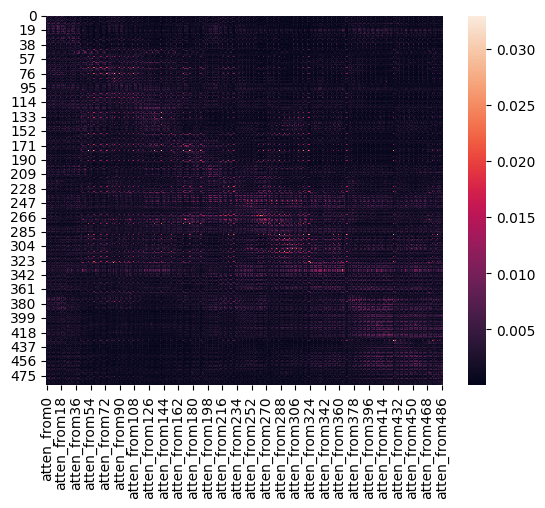

SpeckledBand:Roylott, ranking [1]


,predicate,whom,subject,why,what,where
0,word.predicate:exist,AllTitle:Holmes,AllTitle:Holmes,SpeckledBand:1883-04-02T04,DateTime:1883-04-02T04:00:00,SpeckledBand:Julia_s_bedroom
1,word.predicate:open,AllTitle:Watson,SpeckledBand:Roylott,SpeckledBand:mansion_of_Roylott,SpeckledBand:mansion_of_Roylott,SpeckledBand:Roylott_s_bedroom
2,word.predicate:have,SpeckledBand:Roylott,AllTitle:Watson,SpeckledBand:Roylott_s_bedroom,AllTitle:Holmes,SpeckledBand:mansion_of_Roylott
3,word.predicate:enter,SpeckledBand:Julia_s_bedroom,SpeckledBand:Julia_s_bedroom,DateTime:1883-04-02T04:00:00,DateTime:1883-04-01T15:00:00,AllTitle:Holmes
4,word.predicate:sit,DateTime:1883-04-02T04:00:00,DateTime:1883-04-02T04:00:00,SpeckledBand:Roylott,SpeckledBand:VentilationHole,SpeckledBand:bed
5,DateTime:1883-04-02T04:00:00,DevilsFoot:Mortimer,DevilsFoot:Mortimer,DateTime:1883-04-01T15:00:00,SpeckledBand:1881-04-01,AllTitle:Watson
6,word.predicate:kill,DancingMen:Cubitt,SpeckledBand:mansion_of_Roylott,SpeckledBand:Julia_s_bedroom,SpeckledBand:scream,SpeckledBand:1883-04-02T04
7,word.predicate:meet,DancingMen:Elsie,DancingMen:Cubitt,DateTime:1883-04-02T00:00:00,CrookedMan:owner_of_lodge,SpeckledBand:Roylott
8,word.predicate:marry,SpeckledBand:mansion_of_Roylott,SpeckledBand:VentilationHole,word.predicate:see,SpeckledBand:band,DateTime:1883-04-01T15:00:00
9,word.predicate:lock,SpeckledBand:VentilationHole,SpeckledBand:Helen,SpeckledBand:bed,ACaseOfIdentity:Chair,SilverBlaze:Gregory_Inspector


468

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from468
384,SpeckledBand:344,kgc:hasPredicate,word.predicate:open,0.006449
417,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.006366
38,SpeckledBand:287,kgc:hasPredicate,word.predicate:exist,0.006300
191,SpeckledBand:310,kgc:hasPredicate,word.predicate:smell,0.005726
206,SpeckledBand:313,kgc:hasPredicate,word.predicate:sit,0.005645
108,SpeckledBand:298,kgc:hasPredicate,word.predicate:sit,0.005307
219,SpeckledBand:315,kgc:hasPredicate,word.predicate:smell,0.005187
31,SpeckledBand:286,kgc:hasPredicate,word.predicate:cannotMove,0.004925
76,SpeckledBand:293,kgc:hasPredicate,word.predicate:notMove,0.004744
68,SpeckledBand:292,kgc:hasPredicate,word.predicate:turnOff,0.004727


----------


469

['SpeckledBand:359', 'kgc:subject', 'AllTitle:Holmes']

,head,relation,tail,atten_from469
178,SpeckledBand:308,kgc:hasPredicate,word.predicate:see,0.023687
288,SpeckledBand:327,kgc:hasPredicate,word.predicate:hear,0.021664
134,SpeckledBand:302,kgc:hasPredicate,word.predicate:put,0.014918
324,SpeckledBand:333,kgc:hasPredicate,word.predicate:hear,0.014912
294,SpeckledBand:328,kgc:hasPredicate,word.predicate:cannotSee,0.014683
191,SpeckledBand:310,kgc:hasPredicate,word.predicate:smell,0.013949
428,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.013248
170,SpeckledBand:307,kgc:hasPredicate,word.predicate:hear,0.013188
155,SpeckledBand:305,kgc:hasPredicate,word.predicate:hear,0.012388
371,SpeckledBand:341,kgc:hasPredicate,word.predicate:go,0.012171


----------


470

['SpeckledBand:359', 'kgc:hasPredicate', 'word.predicate:say']

,head,relation,tail,atten_from470
325,SpeckledBand:333,kgc:what,SpeckledBand:scream,0.012754
335,SpeckledBand:335,kgc:hasProperty,word.predicate:crooked_voice,0.010138
338,SpeckledBand:335,kgc:hasProperty,word.predicate:anger_voice,0.009320
330,SpeckledBand:334,kgc:hasProperty,word.predicate:louder,0.009129
336,SpeckledBand:335,kgc:hasProperty,word.predicate:suffering_voice,0.008571
337,SpeckledBand:335,kgc:hasProperty,word.predicate:fear_voice,0.007979
365,SpeckledBand:340,kgc:what,SpeckledBand:handgun,0.007747
263,SpeckledBand:323,kgc:what,SpeckledBand:match,0.007592
161,SpeckledBand:306,kgc:subject,SpeckledBand:leopard,0.006853
429,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.006602


----------


471

['SpeckledBand:359', 'kgc:what', 'SpeckledBand:speckled_band']

,head,relation,tail,atten_from471
325,SpeckledBand:333,kgc:what,SpeckledBand:scream,0.015951
233,SpeckledBand:317,kgc:what,SpeckledBand:sound,0.014231
269,SpeckledBand:324,kgc:what,SpeckledBand:rope_of_bell,0.012782
365,SpeckledBand:340,kgc:what,SpeckledBand:handgun,0.011478
429,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.010778
471,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.008035
103,SpeckledBand:297,kgc:what,SpeckledBand:handgun,0.007943
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.007664
423,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006649
432,SpeckledBand:352,kgc:when,SpeckledBand:1883-04-01T14,0.006645


----------


472

['SpeckledBand:359', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from472
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.007130
433,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.006768
307,SpeckledBand:330,kgc:when,SpeckledBand:1883-04-02T03,0.006520
450,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.006378
467,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.005962
244,SpeckledBand:319,kgc:when,SpeckledBand:1883-04-02T03,0.005845
313,SpeckledBand:331,kgc:when,SpeckledBand:1883-04-02T03,0.005787
409,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.005782
302,SpeckledBand:329,kgc:when,SpeckledBand:1883-04-02T03,0.005493
456,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.005478


----------


473

['SpeckledBand:359', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from473
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.008643
429,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.008271
413,SpeckledBand:349,kgc:when,SpeckledBand:1883-04-02T04,0.007417
374,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.007304
343,SpeckledBand:336,kgc:when,SpeckledBand:1883-04-02T04,0.006817
331,SpeckledBand:334,kgc:when,SpeckledBand:1883-04-02T04,0.006625
325,SpeckledBand:333,kgc:what,SpeckledBand:scream,0.006593
433,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.006553
359,SpeckledBand:339,kgc:infoSource,AllTitle:Holmes,0.006553
386,SpeckledBand:344,kgc:when,SpeckledBand:1883-04-02T04,0.006516


----------


474

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from474
384,SpeckledBand:344,kgc:hasPredicate,word.predicate:open,0.006149
38,SpeckledBand:287,kgc:hasPredicate,word.predicate:exist,0.006149
191,SpeckledBand:310,kgc:hasPredicate,word.predicate:smell,0.006126
417,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.005959
206,SpeckledBand:313,kgc:hasPredicate,word.predicate:sit,0.005467
108,SpeckledBand:298,kgc:hasPredicate,word.predicate:sit,0.005411
219,SpeckledBand:315,kgc:hasPredicate,word.predicate:smell,0.005316
68,SpeckledBand:292,kgc:hasPredicate,word.predicate:turnOff,0.005167
76,SpeckledBand:293,kgc:hasPredicate,word.predicate:notMove,0.004992
31,SpeckledBand:286,kgc:hasPredicate,word.predicate:cannotMove,0.004766


----------


475

['SpeckledBand:360', 'kgc:subject', 'AllTitle:Watson']

,head,relation,tail,atten_from475
428,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.019316
288,SpeckledBand:327,kgc:hasPredicate,word.predicate:hear,0.014739
324,SpeckledBand:333,kgc:hasPredicate,word.predicate:hear,0.013344
268,SpeckledBand:324,kgc:hasPredicate,word.predicate:hit,0.011954
225,SpeckledBand:316,kgc:hasPredicate,word.predicate:hear,0.011217
191,SpeckledBand:310,kgc:hasPredicate,word.predicate:smell,0.011113
232,SpeckledBand:317,kgc:hasPredicate,word.predicate:hear,0.010802
178,SpeckledBand:308,kgc:hasPredicate,word.predicate:see,0.010250
371,SpeckledBand:341,kgc:hasPredicate,word.predicate:go,0.009622
317,SpeckledBand:332,kgc:hasPredicate,word.predicate:see,0.009526


----------


476

['SpeckledBand:360', 'kgc:hasPredicate', 'word.predicate:approach']

,head,relation,tail,atten_from476
433,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.012528
428,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.008435
429,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.007507
374,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.007386
335,SpeckledBand:335,kgc:hasProperty,word.predicate:crooked_voice,0.006508
325,SpeckledBand:333,kgc:what,SpeckledBand:scream,0.006453
367,SpeckledBand:340,kgc:time,DateTime:1883-04-02T04:00:00,0.006008
336,SpeckledBand:335,kgc:hasProperty,word.predicate:suffering_voice,0.005786
420,SpeckledBand:350,kgc:time,DateTime:1883-04-02T04:00:00,0.005586
473,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.005517


----------


477

['SpeckledBand:360', 'kgc:to', 'SpeckledBand:Roylott']

,head,relation,tail,atten_from477
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.011502
433,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007064
185,SpeckledBand:309,kgc:hasPredicate,word.predicate:disappear,0.006301
413,SpeckledBand:349,kgc:when,SpeckledBand:1883-04-02T04,0.006278
408,SpeckledBand:348,kgc:when,SpeckledBand:1883-04-02T04,0.006260
423,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006107
324,SpeckledBand:333,kgc:hasPredicate,word.predicate:hear,0.005794
232,SpeckledBand:317,kgc:hasPredicate,word.predicate:hear,0.005661
143,SpeckledBand:303,kgc:hasPredicate,word.predicate:turnOff,0.005559
82,SpeckledBand:294,kgc:hasPredicate,word.predicate:notice,0.005370


----------


478

['SpeckledBand:360', 'kgc:when', 'SpeckledBand:1883-04-02T04']

,head,relation,tail,atten_from478
433,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008434
307,SpeckledBand:330,kgc:when,SpeckledBand:1883-04-02T03,0.007134
302,SpeckledBand:329,kgc:when,SpeckledBand:1883-04-02T03,0.006808
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.006630
313,SpeckledBand:331,kgc:when,SpeckledBand:1883-04-02T03,0.006575
450,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.006023
277,SpeckledBand:325,kgc:when,SpeckledBand:1883-04-02T03,0.005892
479,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.005816
244,SpeckledBand:319,kgc:when,SpeckledBand:1883-04-02T03,0.005781
467,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.005570


----------


479

['SpeckledBand:360', 'kgc:time', 'DateTime:1883-04-02T04:00:00']

,head,relation,tail,atten_from479
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.011749
374,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.008710
429,SpeckledBand:352,kgc:what,SpeckledBand:dog_whip,0.007979
433,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.007810
411,SpeckledBand:349,kgc:subject,SpeckledBand:Roylott,0.007620
413,SpeckledBand:349,kgc:when,SpeckledBand:1883-04-02T04,0.007027
207,SpeckledBand:313,kgc:infoSource,AllTitle:Watson,0.007005
423,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.006693
479,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.006482
450,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.006383


----------


480

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from480
384,SpeckledBand:344,kgc:hasPredicate,word.predicate:open,0.006479
191,SpeckledBand:310,kgc:hasPredicate,word.predicate:smell,0.006396
38,SpeckledBand:287,kgc:hasPredicate,word.predicate:exist,0.006314
417,SpeckledBand:350,kgc:hasPredicate,word.predicate:exist,0.006227
206,SpeckledBand:313,kgc:hasPredicate,word.predicate:sit,0.005843
108,SpeckledBand:298,kgc:hasPredicate,word.predicate:sit,0.005600
219,SpeckledBand:315,kgc:hasPredicate,word.predicate:smell,0.005553
68,SpeckledBand:292,kgc:hasPredicate,word.predicate:turnOff,0.005354
31,SpeckledBand:286,kgc:hasPredicate,word.predicate:cannotMove,0.005186
76,SpeckledBand:293,kgc:hasPredicate,word.predicate:notMove,0.005167


----------


481

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from481
288,SpeckledBand:327,kgc:hasPredicate,word.predicate:hear,0.025523
178,SpeckledBand:308,kgc:hasPredicate,word.predicate:see,0.016078
294,SpeckledBand:328,kgc:hasPredicate,word.predicate:cannotSee,0.011787
324,SpeckledBand:333,kgc:hasPredicate,word.predicate:hear,0.011575
428,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.011170
268,SpeckledBand:324,kgc:hasPredicate,word.predicate:hit,0.010519
300,SpeckledBand:329,kgc:hasPredicate,word.predicate:see,0.010502
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.009558
232,SpeckledBand:317,kgc:hasPredicate,word.predicate:hear,0.008363
371,SpeckledBand:341,kgc:hasPredicate,word.predicate:go,0.008352


----------


482

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from482
335,SpeckledBand:335,kgc:hasProperty,word.predicate:crooked_voice,0.009008
433,SpeckledBand:352,kgc:time,DateTime:1883-04-01T14:00:00,0.008587
235,SpeckledBand:317,kgc:time,DateTime:1883-04-02T03:00:00,0.008418
467,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.008092
228,SpeckledBand:316,kgc:time,DateTime:1883-04-02T03:00:00,0.007676
374,SpeckledBand:341,kgc:time,DateTime:1883-04-02T04:00:00,0.007429
414,SpeckledBand:349,kgc:time,DateTime:1883-04-02T04:00:00,0.007368
336,SpeckledBand:335,kgc:hasProperty,word.predicate:suffering_voice,0.007332
479,SpeckledBand:360,kgc:time,DateTime:1883-04-02T04:00:00,0.007232
473,SpeckledBand:359,kgc:time,DateTime:1883-04-02T04:00:00,0.007209


----------


483

['mask_e', 'kgc:whom', 'SpeckledBand:Julia']

,head,relation,tail,atten_from483
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.011585
423,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.008419
428,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.008017
207,SpeckledBand:313,kgc:infoSource,AllTitle:Watson,0.007248
268,SpeckledBand:324,kgc:hasPredicate,word.predicate:hit,0.006920
395,SpeckledBand:346,kgc:hasProperty,word.predicate:open,0.005637
133,SpeckledBand:302,kgc:subject,AllTitle:Holmes,0.005280
324,SpeckledBand:333,kgc:hasPredicate,word.predicate:hear,0.005278
225,SpeckledBand:316,kgc:hasPredicate,word.predicate:hear,0.005230
232,SpeckledBand:317,kgc:hasPredicate,word.predicate:hear,0.005124


----------


484

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from484
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.016784
161,SpeckledBand:306,kgc:subject,SpeckledBand:leopard,0.007757
423,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007624
413,SpeckledBand:349,kgc:when,SpeckledBand:1883-04-02T04,0.007025
324,SpeckledBand:333,kgc:hasPredicate,word.predicate:hear,0.006503
428,SpeckledBand:352,kgc:hasPredicate,word.predicate:see,0.006289
395,SpeckledBand:346,kgc:hasProperty,word.predicate:open,0.006141
330,SpeckledBand:334,kgc:hasProperty,word.predicate:louder,0.005974
288,SpeckledBand:327,kgc:hasPredicate,word.predicate:hear,0.005884
408,SpeckledBand:348,kgc:when,SpeckledBand:1883-04-02T04,0.005766


----------


485

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from485
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.014144
411,SpeckledBand:349,kgc:subject,SpeckledBand:Roylott,0.008666
245,SpeckledBand:319,kgc:time,DateTime:1883-04-02T03:00:00,0.008155
240,SpeckledBand:318,kgc:time,DateTime:1883-04-02T03:00:00,0.007866
335,SpeckledBand:335,kgc:hasProperty,word.predicate:crooked_voice,0.007865
423,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.007861
463,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.007133
248,SpeckledBand:320,kgc:time,DateTime:1883-04-02T03:00:00,0.007037
235,SpeckledBand:317,kgc:time,DateTime:1883-04-02T03:00:00,0.006572
467,SpeckledBand:358,kgc:time,DateTime:1883-04-02T04:00:00,0.006562


----------


486

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from486
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.015919
423,SpeckledBand:351,kgc:hasProperty,word.predicate:strapped,0.008541
395,SpeckledBand:346,kgc:hasProperty,word.predicate:open,0.008045
335,SpeckledBand:335,kgc:hasProperty,word.predicate:crooked_voice,0.008012
471,SpeckledBand:359,kgc:what,SpeckledBand:speckled_band,0.007722
338,SpeckledBand:335,kgc:hasProperty,word.predicate:anger_voice,0.007330
330,SpeckledBand:334,kgc:hasProperty,word.predicate:louder,0.007139
411,SpeckledBand:349,kgc:subject,SpeckledBand:Roylott,0.006824
463,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.006545
238,SpeckledBand:318,kgc:hasProperty,word.predicate:softly,0.006280


----------


487

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from487
412,SpeckledBand:349,kgc:hasProperty,word.predicate:wear,0.009902
411,SpeckledBand:349,kgc:subject,SpeckledBand:Roylott,0.008077
335,SpeckledBand:335,kgc:hasProperty,word.predicate:crooked_voice,0.006770
161,SpeckledBand:306,kgc:subject,SpeckledBand:leopard,0.006763
409,SpeckledBand:348,kgc:time,DateTime:1883-04-02T04:00:00,0.006541
456,SpeckledBand:356,kgc:time,DateTime:1883-04-02T04:00:00,0.006111
463,SpeckledBand:358,kgc:subject,SpeckledBand:Roylott,0.006104
450,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.006041
414,SpeckledBand:349,kgc:time,DateTime:1883-04-02T04:00:00,0.005863
245,SpeckledBand:319,kgc:time,DateTime:1883-04-02T03:00:00,0.005786


----------


In [15]:
title = 'SpeckledBand'
victim_name = 'Julia'
killer_name = 'Roylott'
last_index = 360
story_len = 80

df_ranking_SpeckledBand, df_attension_SpeckledBand = main_func01(title, victim_name, killer_name, last_index, story_len)